## IMPORTS ##

In [2]:
import pandas as pd
import numpy as np
import math
import json
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

## FUNCTIONS ##

In [3]:
def read_all_data(PATH='all_data.csv'):
    def convert_circles_info(row):
        data = json.loads(row.replace('\'', '"'))
        vectors = {}
        bcc = []
        scc = []
        for i, (big_circle, small_circle) in enumerate(zip(data['big_circle_centers'], data['small_circle_centers']), start=1):
            x1, y1, _ = big_circle
            x2, y2, _ = small_circle

            bcc.append([x1, y1])
            scc.append([x2, y2])

            dx = x2 - x1
            dy = y2 - y1

            length = round(math.sqrt(dx**2 + dy**2), 3)
            angle_degrees = round(math.degrees(math.atan2(dy, dx)), 3)

            vectors[f'x{i}'] = x1
            vectors[f'y{i}'] = y1
            vectors[f'length{i}'] = length
            if angle_degrees <= 0:
                angle_degrees += 360
            vectors[f'angle_degrees{i}'] = angle_degrees

        # Create an empty list to store points outside the bcc contour
        points_outside_bcc = []
        # Iterate through each point in scc and check if it's outside the bcc contour
        bcc_polygon = np.array([bcc[2], bcc[1], bcc[0], bcc[3], bcc[4], bcc[5]], dtype=np.float32)
        for point in scc:
            distance = cv2.pointPolygonTest(bcc_polygon, (float(point[0]), float(point[1])), True)
            if distance < -8:
                points_outside_bcc.append(point)

        # forecast the outlier if there is
        if len(points_outside_bcc) == 1:
            index = scc.index(points_outside_bcc[0])
            vps = []
            if index in [0,1,2]:
                for i in [0,1,2]:
                    if index != i:
                        vps.append(scc[i][0])
            if index in [3,4,5]:
                for i in [3,4,5]:
                    if index != i:
                        vps.append(scc[i][0])
            new_p = [(vps[0]+vps[1])//2, scc[(index+3)%6][1]]
            vectors[f'x{index+1}'] = new_p[0]
            vectors[f'y{index+1}'] = new_p[1]
            dx = scc[index][0] - bcc[index][0]
            dy = scc[index][1] - bcc[index][1]
            vectors[f'length{index+1}'] = round(math.sqrt(dx**2 + dy**2), 3)
            angle_degrees = round(math.degrees(math.atan2(dy, dx)), 3)
            if angle_degrees <= 0:
                angle_degrees += 360
            vectors[f'angle_degrees{index+1}'] = angle_degrees
        return vectors

    # Read the CSV file with proper data types and converters
    df_all = pd.read_csv('all_data.csv', dtype={'savingID': int, 'height_phone_b': float, 'height_phone_t': float, 'height_phone': float, 'angle_multiplier_info':str}, converters={'circles_info': convert_circles_info})

    # You can create a boolean mask based on the condition
    condition = ((df_all['height_phone'] >= 150) & (df_all['height_phone'] <= 350))

    # Apply the mask to filter the DataFrame
    df_all = df_all[condition]
    
    return df_all


def create_I_O(df_all):
    # Create a new DataFrame with the vectors and height data
    I = pd.DataFrame(df_all.apply(lambda x: x['circles_info'], axis=1).tolist())
    O = pd.DataFrame(df_all['height_phone'])
    return I, O


def normalize(df):
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Normalize
    df[df.columns] = scaler.fit_transform(df[df.columns])
    
    return df


def linear_regression(X_train, X_test, y_train, y_test):
    # Create a Linear Regression model
    model = LinearRegression()

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, y_pred


def random_forest_regressor(X_train, X_test, y_train, y_test, show_features=False):
    # Create a Random Forest Regression model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model on the training data
    rf_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf_model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    if show_features:
        # Optionally, you can visualize feature importances if you want to understand which features are important for the model.
        feature_importances = rf_model.feature_importances_
        feature_names = X_train.columns

        # Create a bar chart to visualize feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, feature_importances)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Name')
        plt.title('Random Forest Feature Importances')
        plt.show()
    
    return mse, r2, y_pred 


def support_vector_regression(X_train, X_test, y_train, y_test):
    # Create a support vector regression model
    model = SVR(kernel='linear')

    # Fit the model to the data
    model.fit(X_train, y_train)

    # Predict the response for a new data point
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, y_pred


def lasso_regression(X_train, X_test, y_train, y_test):
    # Create a lasso regression model
    model = Lasso(alpha=0.1)

    # Fit the model to the data
    model.fit(X_train, y_train)

    # Predict the response for a new data point
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2, y_pred


def split_data(I, O):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(I, O, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


def create_dfs(y_test, y_pred_LR, y_pred_SVR, y_pred_LAR, y_pred_RFR):
    # Create DataFrames for actual and predicted heights for both models
    actual_heights = y_test.reset_index(drop=True)
    predicted_heights_LR = pd.DataFrame(y_pred_LR, columns=['Predicted Height (LR)'])
    predicted_heights_SVR = pd.DataFrame(y_pred_SVR, columns=['Predicted Height (SVR)'])
    predicted_heights_LAR = pd.DataFrame(y_pred_LAR, columns=['Predicted Height (LAR)'])
    predicted_heights_RFR = pd.DataFrame(y_pred_RFR, columns=['Predicted Height (RFR)'])

    # Calculate the differences between actual and predicted heights for both models
    difference_LR = pd.DataFrame((actual_heights['height_phone'] - predicted_heights_LR['Predicted Height (LR)']).values, columns=['Height Difference (LR)'])
    difference_SVR = pd.DataFrame((actual_heights['height_phone'] - predicted_heights_SVR['Predicted Height (SVR)']).values, columns=['Height Difference (SVR)'])
    difference_LAR = pd.DataFrame((actual_heights['height_phone'] - predicted_heights_LAR['Predicted Height (LAR)']).values, columns=['Height Difference (LAR)'])
    difference_RFR = pd.DataFrame((actual_heights['height_phone'] - predicted_heights_RFR['Predicted Height (RFR)']).values, columns=['Height Difference (RFR)'])

    return actual_heights, predicted_heights_LR, predicted_heights_SVR, predicted_heights_LAR, predicted_heights_RFR, difference_LR, difference_SVR, difference_LAR, difference_RFR


def compare_results(actual_heights, predicted_heights_LR, predicted_heights_SVR, predicted_heights_LAR, predicted_heights_RFR):
    # Create subplots with 5 rows and 1 column
    fig, axs = plt.subplots(5, 1, figsize=(12, 20))

    # Subplot 1: Comparison for Linear Regression
    axs[0].scatter(predicted_heights_LR.index, predicted_heights_LR['Predicted Height (LR)'], label='Predicted Height (LR)', color='blue', alpha=0.7)
    axs[0].scatter(actual_heights.index, actual_heights['height_phone'], label='Actual Height', color='black', alpha=0.7)
    axs[0].set_xlabel('Sample Index')
    axs[0].set_ylabel('Height')
    axs[0].set_title('Actual vs. Predicted Heights - Linear Regression')
    axs[0].legend()

    # Subplot 2: Comparison for Support Vector Regression (SVR)
    axs[1].scatter(predicted_heights_SVR.index, predicted_heights_SVR['Predicted Height (SVR)'], label='Predicted Height (SVR)', color='green', alpha=0.7)
    axs[1].scatter(actual_heights.index, actual_heights['height_phone'], label='Actual Height', color='black', alpha=0.7)
    axs[1].set_xlabel('Sample Index')
    axs[1].set_ylabel('Height')
    axs[1].set_title('Actual vs. Predicted Heights - Support Vector Regression (SVR)')
    axs[1].legend()

    # Subplot 3: Comparison for Least Angle Regression (LAR)
    axs[2].scatter(predicted_heights_LAR.index, predicted_heights_LAR['Predicted Height (LAR)'], label='Predicted Height (LAR)', color='purple', alpha=0.7)
    axs[2].scatter(actual_heights.index, actual_heights['height_phone'], label='Actual Height', color='black', alpha=0.7)
    axs[2].set_xlabel('Sample Index')
    axs[2].set_ylabel('Height')
    axs[2].set_title('Actual vs. Predicted Heights - Least Angle Regression (LAR)')
    axs[2].legend()

    # Subplot 4: Comparison for Random Forest Regression (RFR)
    axs[3].scatter(predicted_heights_RFR.index, predicted_heights_RFR['Predicted Height (RFR)'], label='Predicted Height (RFR)', color='red', alpha=0.7)
    axs[3].scatter(actual_heights.index, actual_heights['height_phone'], label='Actual Height', color='black', alpha=0.7)
    axs[3].set_xlabel('Sample Index')
    axs[3].set_ylabel('Height')
    axs[3].set_title('Actual vs. Predicted Heights - Random Forest Regression (RFR)')
    axs[3].legend()

    # Subplot 5: Combined Comparison
    axs[4].scatter(predicted_heights_LR.index, predicted_heights_LR['Predicted Height (LR)'], label='Predicted Height (LR)', color='blue', alpha=0.5)
    axs[4].scatter(predicted_heights_SVR.index, predicted_heights_SVR['Predicted Height (SVR)'], label='Predicted Height (SVR)', color='green', alpha=0.5)
    axs[4].scatter(predicted_heights_LAR.index, predicted_heights_LAR['Predicted Height (LAR)'], label='Predicted Height (LAR)', color='purple', alpha=0.5)
    axs[4].scatter(predicted_heights_RFR.index, predicted_heights_RFR['Predicted Height (RFR)'], label='Predicted Height (RFR)', color='black', alpha=0.5)
    axs[4].scatter(actual_heights.index, actual_heights['height_phone'], label='Actual Height', color='black', alpha=0.7)
    axs[4].set_xlabel('Sample Index')
    axs[4].set_ylabel('Height')
    axs[4].set_title('Actual vs. Predicted Heights - Combined (LR, SVR, LAR, RFR)')
    axs[4].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the subplots
    plt.show()


def compare_distances(actual_heights, difference_LR, difference_SVR, difference_LAR, difference_RFR):
    # Create subplots with 3 rows and 1 column
    fig, axs = plt.subplots(5, 1, figsize=(12, 20))

    # Subplot 1: Difference for Linear Regression
    axs[0].bar(actual_heights.index, difference_LR['Height Difference (LR)'], label='Difference (LR)', color='blue', alpha=0.7)
    axs[0].set_xlabel('Sample Index')
    axs[0].set_ylabel('Height Difference (LR)')
    axs[0].set_title('Height Differences (Actual - Predicted) - Linear Regression')
    axs[0].legend()

    # Subplot 2: Difference for Support Vector Regression (SVR)
    axs[1].bar(actual_heights.index, difference_SVR['Height Difference (SVR)'], label='Difference (SVR)', color='green', alpha=0.7)
    axs[1].set_xlabel('Sample Index')
    axs[1].set_ylabel('Height Difference (SVR)')
    axs[1].set_title('Height Differences (Actual - Predicted) - Support Vector Regression (SVR)')
    axs[1].legend()

    # Subplot 3: Difference for Least Angle Regression (LAR)
    axs[2].bar(actual_heights.index, difference_LAR['Height Difference (LAR)'], label='Difference (LAR)', color='purple', alpha=0.7)
    axs[2].set_xlabel('Sample Index')
    axs[2].set_ylabel('Height Difference (LAR)')
    axs[2].set_title('Height Differences (Actual - Predicted) - Least Angle Regression (LAR)')
    axs[2].legend()

    # Subplot 4: Difference for Random Forest Regression (RFR)
    axs[3].bar(actual_heights.index, difference_RFR['Height Difference (RFR)'], label='Difference (RFR)', color='red', alpha=0.7)
    axs[3].set_xlabel('Sample Index')
    axs[3].set_ylabel('Height Difference (RFR)')
    axs[3].set_title('Height Differences (Actual - Predicted) - Random Forest Regression (RFR)')
    axs[3].legend()

    # Subplot 5: Combined Difference
    axs[4].bar(actual_heights.index, difference_LR['Height Difference (LR)'], label='Difference (LR)', color='blue', alpha=0.5)
    axs[4].bar(actual_heights.index, difference_SVR['Height Difference (SVR)'], label='Difference (SVR)', color='green', alpha=0.5)
    axs[4].bar(actual_heights.index, difference_LAR['Height Difference (LAR)'], label='Difference (LAR)', color='purple', alpha=0.5)
    axs[4].bar(actual_heights.index, difference_RFR['Height Difference (RFR)'], label='Difference (RFR)', color='red', alpha=0.5)
    axs[4].set_xlabel('Sample Index')
    axs[4].set_ylabel('Height Difference')
    axs[4].set_title('Height Differences (Actual - Predicted) - Combined (LR, SVR, LAR, RFR)')
    axs[4].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the subplots
    plt.show()


def compare_errors(mse_LR, mse_SVR, mse_LAR, mse_RFR, r2_LR, r2_SVR, r2_LAR, r2_RFR, abs_sum_diff_LR, abs_sum_diff_SVR, abs_sum_diff_LAR, abs_sum_diff_RFR):
    abs_ave_diff_LR = abs_sum_diff_LR/len(y_test)
    abs_ave_diff_SVR = abs_sum_diff_SVR/len(y_test)
    abs_ave_diff_LAR = abs_sum_diff_LAR/len(y_test)
    abs_ave_diff_RFR = abs_sum_diff_RFR/len(y_test)
    
    # Create bar charts for MSEs and R^2 scores
    plt.figure(figsize=(8, 12))

    # Bar chart for MSEs
    plt.subplot(4, 1, 1)
    plt.bar(['Linear Regression', 'Support Vector Regression', 'Lasso Regression', 'Random Forest Regression'], [mse_LR, mse_SVR, mse_LAR, mse_RFR], color=['blue', 'green', 'purple', 'red'])
    plt.xlabel('Model')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Comparison of Mean Squared Error (MSE) between Models')

    # Bar chart for R^2 scores
    plt.subplot(4, 1, 2)
    plt.bar(['Linear Regression', 'Support Vector Regression', 'Lasso Regression', 'Random Forest Regression'], [r2_LR, r2_SVR, r2_LAR, r2_RFR], color=['blue', 'green', 'purple', 'red'])
    plt.xlabel('Model')
    plt.ylabel('R-squared (R^2) Score')
    plt.title('Comparison of R-squared (R^2) Score between Models')

    # Bar chart for abs sum differences
    plt.subplot(4, 1, 3)
    plt.bar(['Linear Regression', 'Support Vector Regression', 'Lasso Regression', 'Random Forest Regression'], [abs_sum_diff_LR, abs_sum_diff_SVR, abs_sum_diff_LAR, abs_sum_diff_RFR], color=['blue', 'green', 'purple', 'red'])
    plt.xlabel('Model')
    plt.ylabel('Absolute Sum Differences')
    plt.title('Comparison of Absolute Sum Differences between Models')

    # Bar chart for average differences
    plt.subplot(4, 1, 4)
    plt.bar(['Linear Regression', 'Support Vector Regression', 'Lasso Regression', 'Random Forest Regression'], [abs_ave_diff_LR, abs_ave_diff_SVR, abs_ave_diff_LAR, abs_ave_diff_RFR], color=['blue', 'green', 'purple', 'red'])
    plt.xlabel('Model')
    plt.ylabel('Average Differences')
    plt.title('Comparison of Average Differences between Models')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the bar charts
    plt.show()

## CODE ##

In [4]:
df_all = read_all_data('all_data.csv')
#df_all = df_all.drop(df_all[df_all['angle_multiplier_info'] == 'Wrong Circle Detection'].index)
I, O = create_I_O(df_all)
I = normalize(I)
X_train, X_test, y_train, y_test = split_data(I, O)

mse_LR, r2_LR, y_pred_LR = linear_regression(X_train, X_test, y_train, y_test)
mse_SVR, r2_SVR, y_pred_SVR = support_vector_regression(X_train, X_test, y_train, y_test)
mse_LAR, r2_LAR, y_pred_LAR = lasso_regression(X_train, X_test, y_train, y_test)
mse_RFR, r2_RFR, y_pred_RFR = random_forest_regressor(X_train, X_test, y_train, y_test, show_features=False)

actual_heights, predicted_heights_LR, predicted_heights_SVR, predicted_heights_LAR, predicted_heights_RFR, difference_LR, difference_SVR, difference_LAR, difference_RFR = create_dfs(y_test, y_pred_LR, y_pred_SVR, y_pred_LAR, y_pred_RFR)

abs_sum_diff_LR = sum(abs(num) for num in difference_LR['Height Difference (LR)'])
abs_sum_diff_SVR = sum(abs(num) for num in difference_SVR['Height Difference (SVR)'])
abs_sum_diff_LAR = sum(abs(num) for num in difference_LAR['Height Difference (LAR)'])
abs_sum_diff_RFR = sum(abs(num) for num in difference_RFR['Height Difference (RFR)'])

C:\Users\alper\anaconda3\envs\height_estimation\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alper\anaconda3\envs\height_estimation\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## RESULTS ##

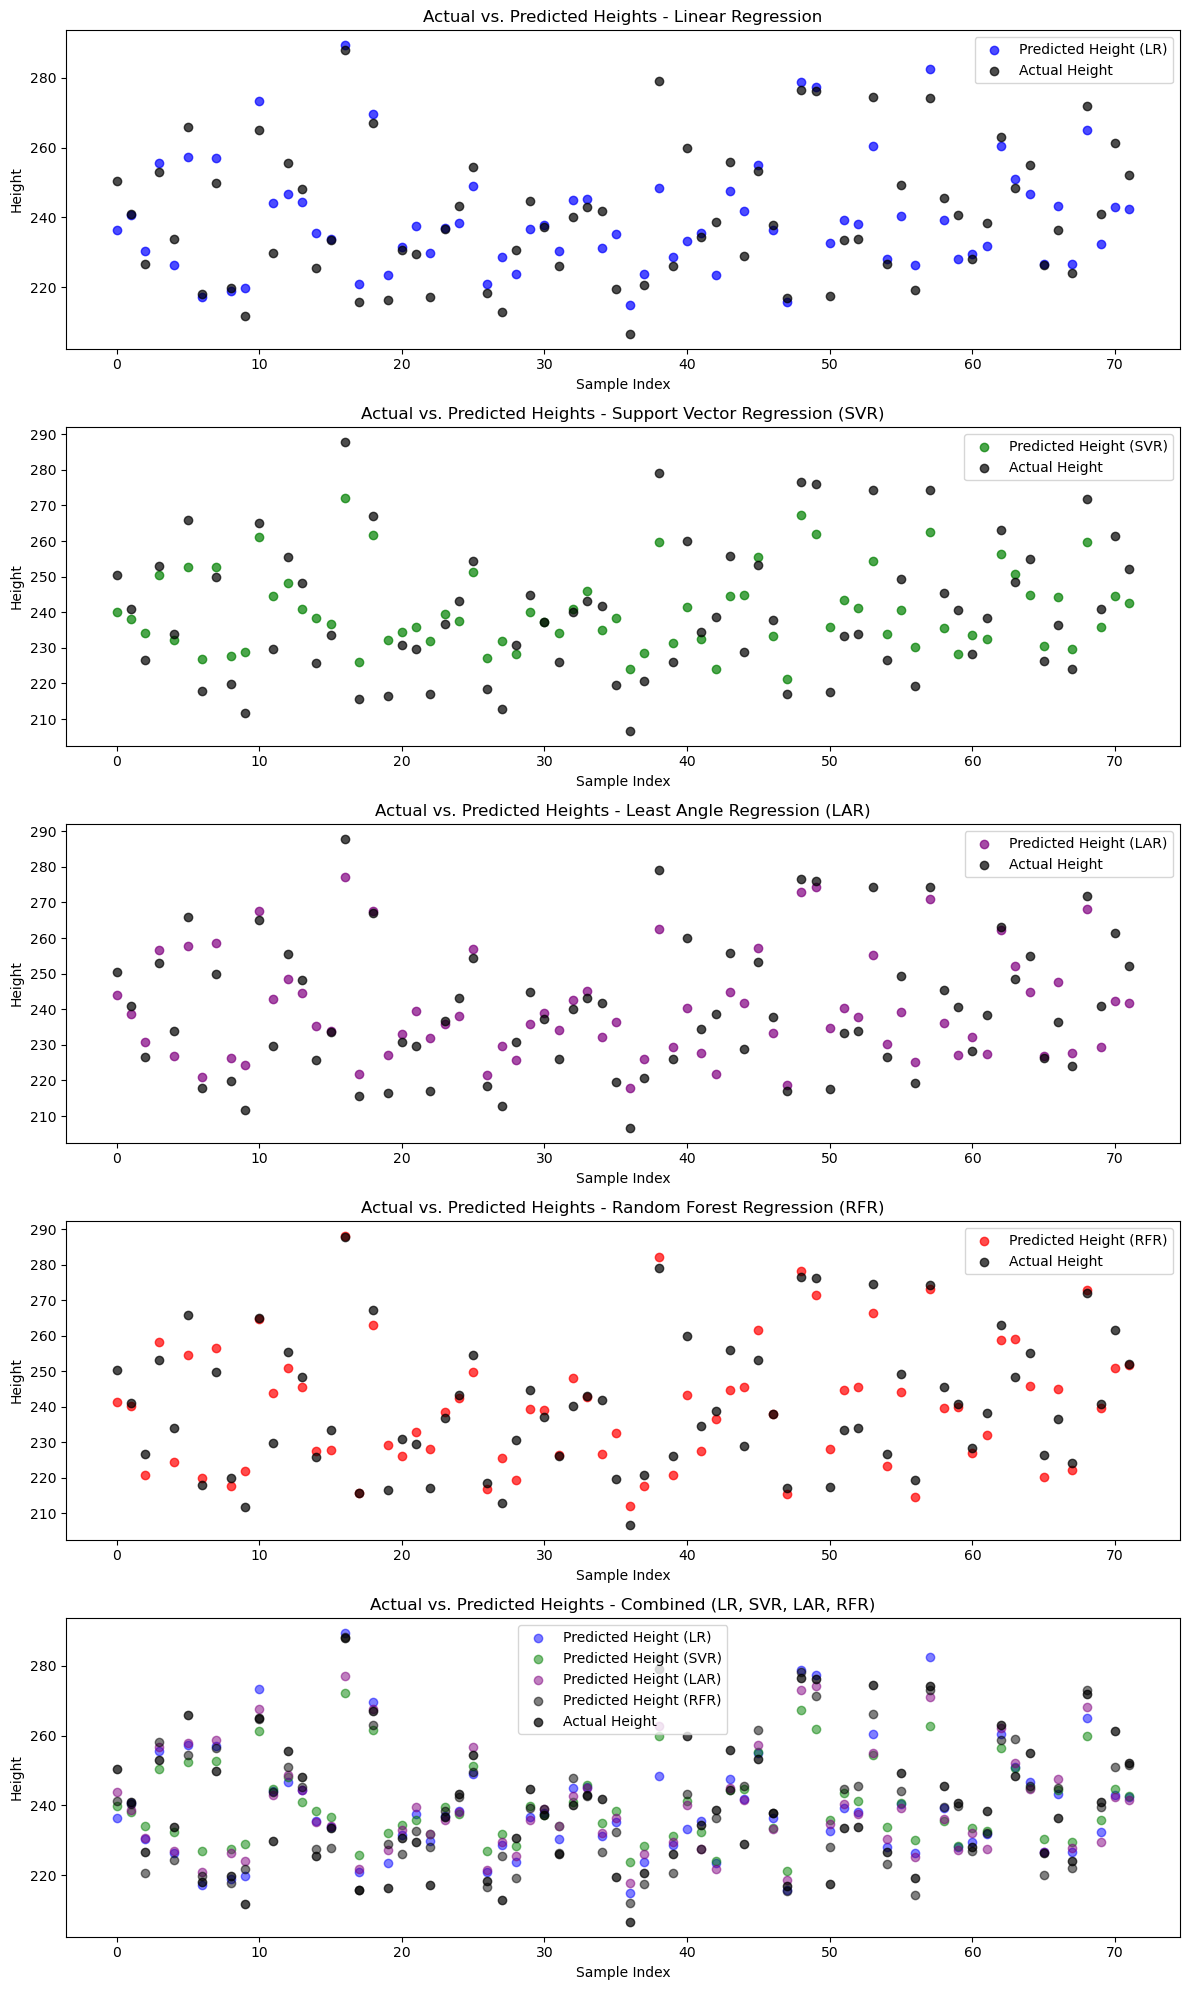

In [5]:
compare_results(actual_heights, predicted_heights_LR, predicted_heights_SVR, predicted_heights_LAR, predicted_heights_RFR)

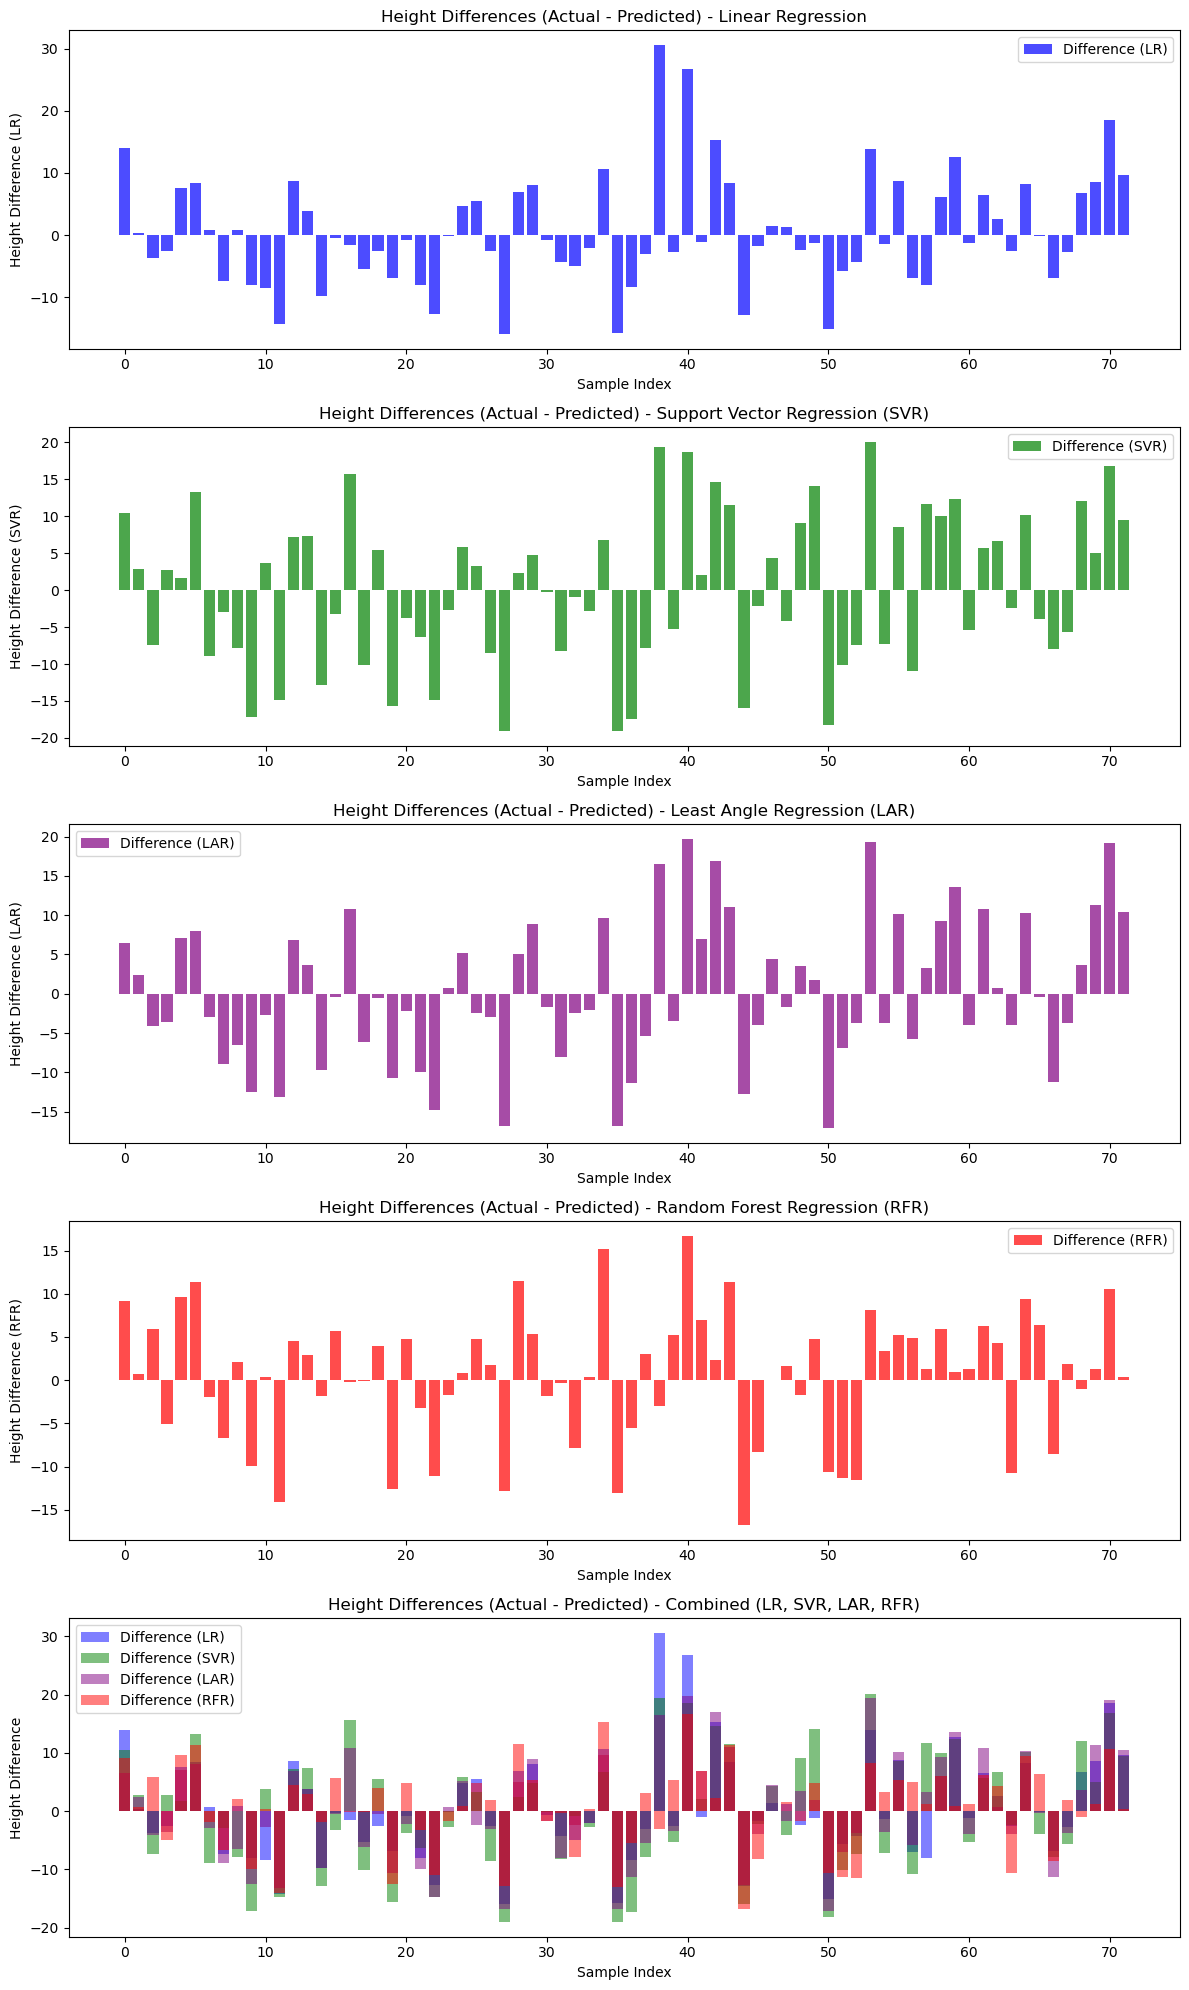

In [6]:
compare_distances(actual_heights, difference_LR, difference_SVR, difference_LAR, difference_RFR)

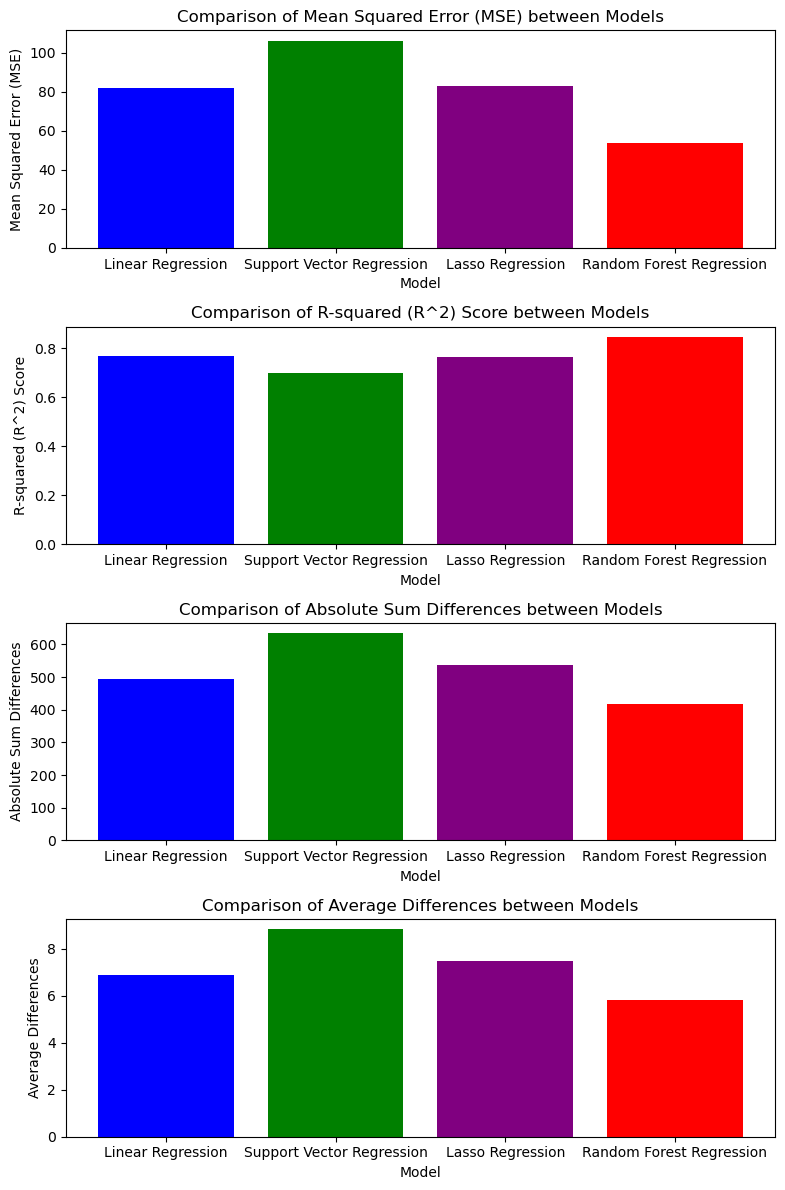

In [7]:
compare_errors(mse_LR, mse_SVR, mse_LAR, mse_RFR, r2_LR, r2_SVR, r2_LAR, r2_RFR, abs_sum_diff_LR, abs_sum_diff_SVR, abs_sum_diff_LAR, abs_sum_diff_RFR)